# `microguilds` tutorial
This tutorial will guide you through a use case using a mock mastertable.

### Table of contents
1. Enrichment analysis. --of environmental factors across the internal nodes of a phylogenetic tree.
2. Filtering significant nodes. --filter-out significant nodes whose parent is also significant.
3. Clustering the phylogenetic tree. --into large groups of taxons sharing environmental properties.
4. Sample placement. --Place the metagenomic samples in the tree and identify their cluster.
5. Compute a guilds' k tensor. 
6. Visualize a guilds' k tensor.
7. Interpret the results.

### Import libraries


In [2]:
import warnings
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import functional_clustering_utils as fcutils
from tqdm import tqdm

### Setup important variables

In [3]:
# Input
GENE = "mocK"
FILENAME_ENV_DATA = './environmental_data_mock.csv'
FILENAME_TREE = f'./{GENE}_tree.newick'
MCMAX = 9999

# Output
FILENAME_CLADE_DATA = f'./{GENE}_clades.npz'
FILENAME_OUT = f'./{GENE}_enrichment.npz'

### 1. Enrichment analysis

##### First load environmental data

In [26]:
# Load environmental feature matrix
df = pd.read_csv(FILENAME_ENV_DATA, sep=";", encoding='utf8')
ft = df.to_numpy()

# Extract useful info
SPECIES_NAMES = np.array([line[0] for line in ft])
FEATURES_NAMES = np.array([col for col in df.columns])[1:16]
FEATURES_SPECIES = np.array([line[1:16] for line in ft])
NFEATURES = FEATURES_SPECIES.shape[1]

print(f"Succesfully loaded {FILENAME_ENV_DATA}")
df.head(12)

Succesfully loaded ./environmental_data_mock.csv


,organism,temp,pH
0,Vibrio fictivorax,37,7
1,Salmonella imagina,36,7
2,Escherichia ficticola,37,7
3,Mycobacterium fictum,34,7
4,Lactobacillus fictobacter,15,8
5,Bacillus fictilis,13,8
6,Acinetobacter imaginensis,14,8
7,Pseudomonas fictosa,15,4
8,Streptomyces fictivus,14,5
9,Bacteroides fictus,15,5


##### Now load the phylogenetic tree

In [27]:
# Compute clade data
data = fcutils.get_clade_data(
    FILENAME_TREE,
    treetype="newick",
    filename_out=None #FILENAME_CLADE_DATA
)

# Extract important variables
clade_ids, clade_lfs, clade_dpt, leaf_names = data

GENUS = np.array([fcutils.get_genus(name) for name in leaf_names])
SPECIES = np.array([fcutils.get_species(name) for name in leaf_names])
NLEAFS = len(leaf_names)
NCLADES = len(clade_ids)
CLADE_NLEAFS = np.array([len(leafs) for leafs in clade_lfs])

100%|██████████| 8/8 [00:00<00:00, 7726.10it/s]


Data loaded from ./mocK_tree.newick.
Found data for > 11 leafs,
               > 8 internal nodes.


##### Build the features matrix

Find for which organism of the tree we have environmental info in the table, and build a features matrix. 

Observe that there is missing environmental data for just one organism.

In [28]:
print("")

FEATURES = np.zeros((NLEAFS, NFEATURES)) * np.nan

# Fill feature matrix of the organisms found in the tree
for idx_sp, species in tqdm(enumerate(SPECIES_NAMES)):
    _speacies_name = species.split(' ')
    for idx_leaf, leaf in enumerate(leaf_names):
        # If "species" is matched to the tree "leaf"
        if (_speacies_name[0] in leaf) and (_speacies_name[1] in leaf):
            FEATURES[idx_leaf, :] = FEATURES_SPECIES[idx_sp, :]

_missing_data = np.sum(np.all(np.isnan(FEATURES), axis=1))
_not_missing_data = FEATURES.shape[0] - _missing_data
idx_missing = np.argwhere(np.all(np.isnan(FEATURES), axis=1))[:, 0]
print(f'\nData obtained for {_not_missing_data} tree entries.')
print(f'Data missing  for {_missing_data} tree entries.')
_ = [print(f"  -[{_:4d}] {GENUS[_]} {SPECIES[_]}") for _ in idx_missing]

10it [00:00, ?it/s]


Data obtained for 10 tree entries.
Data missing  for 1 tree entries.
  -[   9] Clostridium imaginarium


And now randomize values and compute the enrichment as z-scores.

In [29]:
# Declare accumulators
ZSCORES = np.zeros((NCLADES, NFEATURES)) * np.nan

# Compute randomizations for every internal node
for idx_clade, _leafs in tqdm(enumerate(clade_lfs), total=NCLADES):
    
    # Compute true observed values for each feature
    obs_mean = np.nanmean(FEATURES[_leafs, :], axis=0)

    # Randomize values
    values_mc = np.zeros((MCMAX, NFEATURES))
    for imc in range(MCMAX):
        rr = np.random.permutation(NLEAFS)[:len(_leafs)]
        values_mc[imc, :] = np.nanmean(FEATURES[rr, :], axis=0)

    # Compute and store z-scores
    mc_mean = np.nanmean(values_mc, axis=0)
    mc_std = np.nanstd(values_mc, axis=0)
    mc_std[np.abs(mc_std) <= 1e-8] = np.nan
    ZSCORES[idx_clade, :] = (obs_mean - mc_mean) / mc_std
print("Finished.")


100%|██████████| 8/8 [00:03<00:00,  2.13it/s]

Finished.


##### Create some visualization to get a sense of the data.
Observe that there seem to be three different clusters:
1. High temp and mean pH
2. Low temp and high pH
3. Low temp and low pH

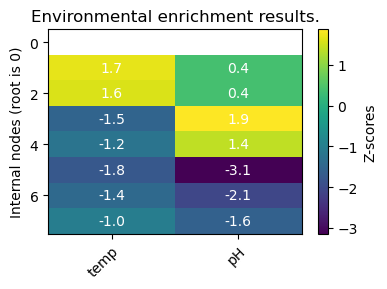

In [48]:
fig, ax = plt.subplots(figsize=(4,3), dpi=100)
im = ax.imshow(ZSCORES, aspect="auto")

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(FEATURES_NAMES)), labels=FEATURES_NAMES)
#ax.set_yticks(np.arange(len(vegetables)), labels=vegetables)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(ZSCORES.shape[0]):
    for j in range(len(FEATURES_NAMES)):
        text = ax.text(j, i, f"{ZSCORES[i, j]:0.1f}",
                       ha="center", va="center", color="w")

ax.set_ylabel("Internal nodes (root is 0)")
ax.set_title("Environmental enrichment results.")
fig.colorbar(im, label="Z-scores")
plt.tight_layout()
plt.show()